# Imports

In [ ]:
import os
import shutil
import time
from tqdm import tqdm
import random

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import PIL.Image
from IPython.display import Image
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torchvision
from torchvision import models,transforms,datasets

# Visualizing and preparing data

In [ ]:
path_train = "/imgs/train"
classes = [c for c in os.listdir(path_train) if not c.startswith(".")]
classes.sort()
print(classes)

['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']


In [ ]:
class_dict = {0 : "safe driving",
              1 : "texting - right",
              2 : "talking on the phone - right",
              3 : "texting - left",
              4 : "talking on the phone - left",
              5 : "operating the radio",
              6 : "drinking",
              7 : "reaching behind",
              8 : "hair and makeup",
              9 : "talking to passenger"}

Total number of training data : 22424


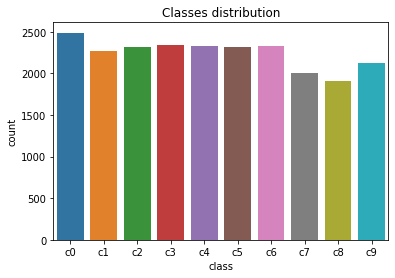

In [ ]:
d = {"img" : [], "class" : []}
for c in classes:
    imgs = [img for img in os.listdir(os.path.join(path_train,c)) if not img.startswith(".")]
    for img in imgs:
        d["img"].append(img)
        d["class"].append(c)
df = pd.DataFrame(d)
ax = sns.countplot(data=df,x="class")
ax.set(title="Classes distribution")
print("Total number of training data :",len(df))

In [ ]:
transform = transforms.Compose([transforms.Resize((400, 400)),
                                 transforms.RandomRotation(10),
                                 transforms.ToTensor()])

In [ ]:
data = datasets.ImageFolder(root = path_train, transform = transform)

total_len = len(data)
training_len = int(0.8*total_len)
testing_len = total_len - training_len

training_data,testing_data = torch.utils.data.random_split(data,(training_len,testing_len))

In [ ]:
train_loader = torch.utils.data.DataLoader(dataset=training_data,
                                           batch_size=64,
                                           shuffle=True,
                                           drop_last=False)
test_loader = torch.utils.data.DataLoader(dataset=testing_data,
                                          batch_size=64,
                                          shuffle=False,
                                          drop_last=False)

torch.Size([3, 400, 400])
Label: c0 (safe driving)


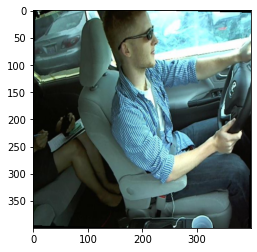

In [ ]:
img,c = data[0]
print(img.shape)
print("Label:", classes[c], f"({class_dict[c]})")
plt.imshow(img.permute(1,2,0))
plt.show()

torch.Size([64, 3, 400, 400])
tensor([[3, 8, 1, 4, 2, 3, 4, 9],
        [4, 0, 1, 4, 0, 7, 5, 6],
        [5, 7, 3, 1, 8, 0, 3, 2],
        [9, 6, 4, 5, 4, 2, 3, 9],
        [5, 0, 8, 8, 5, 6, 1, 9],
        [5, 4, 9, 0, 1, 5, 8, 6],
        [0, 3, 0, 0, 6, 2, 0, 5],
        [0, 0, 4, 2, 4, 8, 3, 7]])


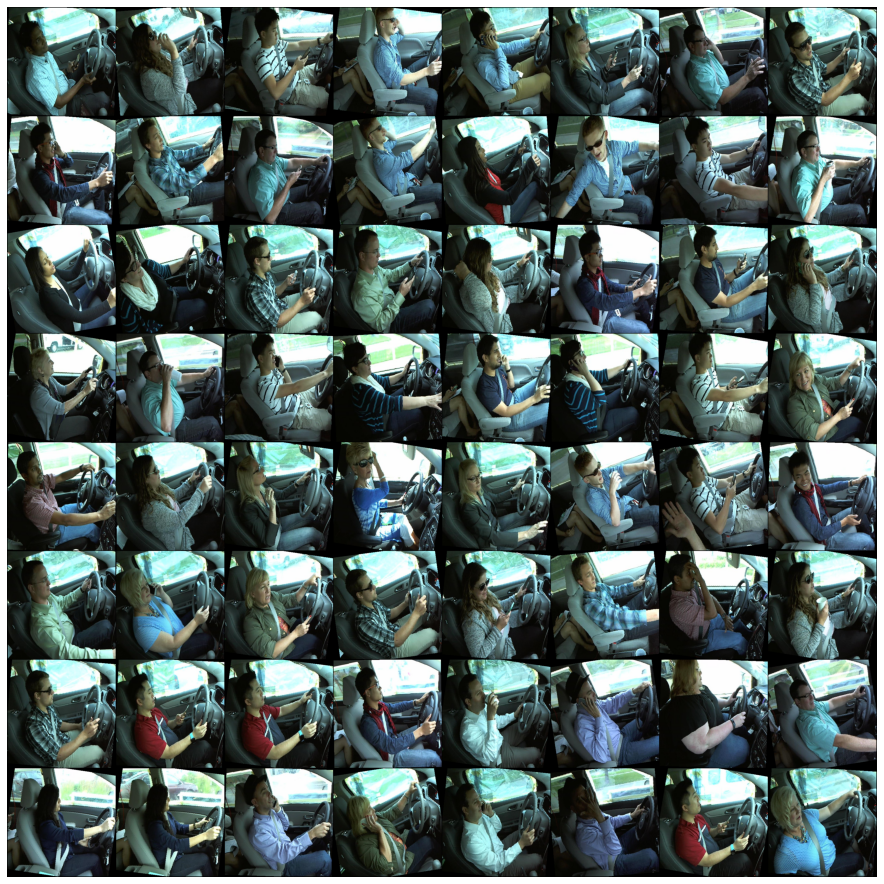

In [ ]:
loader,labels = next(iter(train_loader))
print(loader.shape)
print(labels.view(8,8))
plt.figure(figsize=(16,16))
plt.imshow(torchvision.utils.make_grid(loader,nrow=8).permute((1,2,0)))
plt.axis('off')
plt.show()

# Creating and training the model

In [ ]:
device = torch.device("cuda:0")
print(device)
print(torch.cuda.get_device_name(device))

cuda:0
Tesla P100-PCIE-16GB


The model works better with 'normalized' data.

In [ ]:
transform = transforms.Compose([transforms.Resize((400, 400)),
                           transforms.RandomRotation(10),
                           transforms.ToTensor(),
                           transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                          ])

In [ ]:
data = datasets.ImageFolder(root = path_train, transform = transform)

total_len = len(data)
training_len = int(0.8*total_len)
testing_len = total_len - training_len

training_data,testing_data = torch.utils.data.random_split(data,(training_len,testing_len))

In [ ]:
train_loader = torch.utils.data.DataLoader(dataset=training_data,
                                           batch_size=32,
                                           shuffle=True,
                                           drop_last=False,
                                           num_workers=2)
test_loader = torch.utils.data.DataLoader(dataset=testing_data,
                                          batch_size=32,
                                          shuffle=False,
                                          drop_last=False,
                                          num_workers=2)

In [ ]:
def train_model(model, criterion, optimizer, scheduler, n_epochs = 5):
    
    losses = []
    accuracies = []
    test_accuracies = []
    # set the model to train mode initially
    model.train()
    for epoch in tqdm(range(n_epochs)):
        since = time.time()
        running_loss = 0.0
        running_correct = 0.0
        for data in train_loader:

            # get the inputs and assign them to cuda
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            
            # forward + backward + optimize
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            # calculate the loss/acc later
            running_loss += loss.item()
            running_correct += (labels==predicted).sum().item()

        epoch_duration = time.time()-since
        epoch_loss = running_loss/len(train_loader)
        epoch_acc = 100/32*running_correct/len(train_loader)

        print("Epoch %s, duration: %d s, loss: %.4f, acc: %.4f" % (epoch+1, epoch_duration, epoch_loss, epoch_acc))
        
        losses.append(epoch_loss)
        accuracies.append(epoch_acc)
        
        # switch the model to eval mode to evaluate on test data
        model.eval()
        test_acc = eval_model(model)
        test_accuracies.append(test_acc)
        
        # re-set the model to train mode after validating
        model.train()
        scheduler.step(test_acc)
        since = time.time()
    print('Finished Training')
    return model, losses, accuracies, test_accuracies

In [ ]:
def eval_model(model):
    correct = 0.0
    total = 0.0
    with torch.no_grad():
        for i, data in enumerate(test_loader, 0):
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model_ft(images)
            _, predicted = torch.max(outputs.data, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_acc = 100.0 * correct / total
    print('Accuracy of the network on the test images: %d %%' % (
        test_acc))
    return test_acc

In [ ]:
model_ft = models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, 10) #No. of classes = 10
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)
lrscheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, threshold = 0.9)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
# takes around 5-6 minutes per epoch with GPU
model_ft, training_losses, training_accs, test_accs = train_model(model_ft, criterion, optimizer, lrscheduler, n_epochs=3)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1, duration: 331 s, loss: 0.2533, acc: 91.8004


 33%|███▎      | 1/3 [06:36<13:12, 396.23s/it]

Accuracy of the network on the test images: 98 %
Epoch 2, duration: 311 s, loss: 0.0245, acc: 99.2034


 67%|██████▋   | 2/3 [12:45<06:20, 380.60s/it]

Accuracy of the network on the test images: 98 %
Epoch 3, duration: 313 s, loss: 0.0110, acc: 99.5822


100%|██████████| 3/3 [18:57<00:00, 379.22s/it]

Accuracy of the network on the test images: 99 %
Finished Training


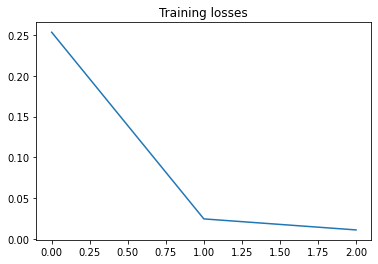

In [ ]:
plt.title('Training losses')
plt.plot(training_losses)
plt.show()

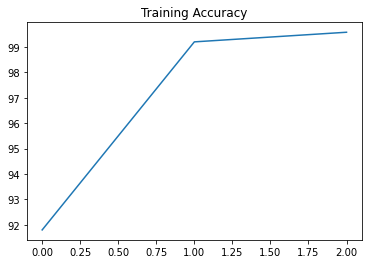

In [ ]:
plt.title('Training Accuracy')
plt.plot(training_accs)
plt.show()

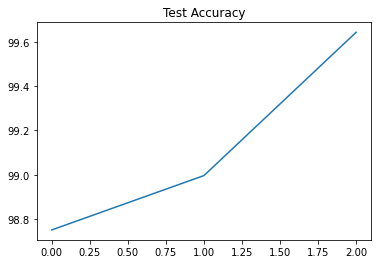

In [ ]:
plt.title('Test Accuracy')
plt.plot(test_accs)
plt.show()

In [ ]:
torch.save(model_ft,"model-best.hd5")

In [ ]:
torch.save(model_ft.state_dict(), "model-driver")

# Testing the model

In [ ]:
model = models.resnet50()
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)
model.load_state_dict(torch.load("model-driver"))
model.eval()
model.cuda()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
path_test = "/imgs/test"
list_img_test = [img for img in os.listdir(path_test) if not img.startswith(".")]
list_img_test.sort()

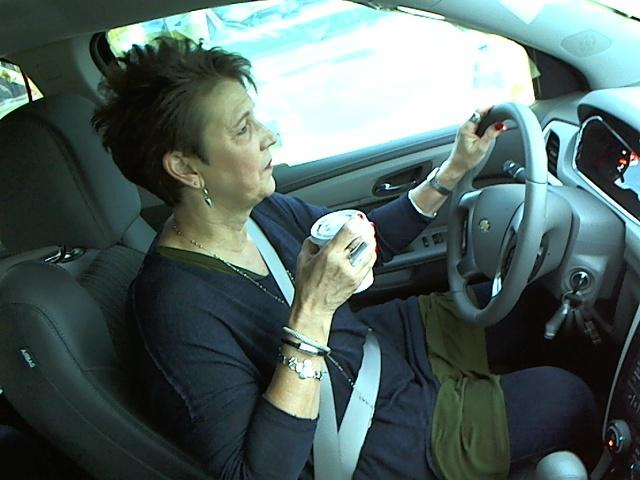

[0.0, 0.0001, 0.0, 0.0, 0.0, 0.0, 0.9999, 0.0, 0.0, 0.0]
Predicted class: drinking
Confidence: 0.9999
2nd answer: texting - right
Confidence: 0.0001


In [ ]:
file = random.choice(list_img_test)
im_path = os.path.join(path_test,file)
display(Image(filename=im_path))
with PIL.Image.open(im_path) as im:
    im = transform(im)
    im = im.unsqueeze(0)
    output = model(im.cuda())
    proba = nn.Softmax(dim=1)(output)
    proba = [round(float(elem),4) for elem in proba[0]]
    print(proba)
    print("Predicted class:",class_dict[proba.index(max(proba))])
    print("Confidence:",max(proba))
    proba2 = proba.copy()
    proba2[proba2.index(max(proba2))] = 0.
    print("2nd answer:",class_dict[proba2.index(max(proba2))])
    print("Confidence:",max(proba2))

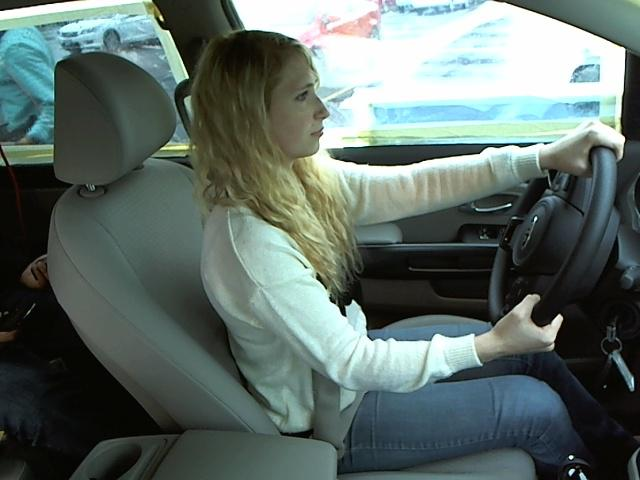

[0.995, 0.0, 0.0001, 0.0011, 0.0023, 0.0003, 0.0002, 0.0001, 0.0005, 0.0003]
Predicted class: safe driving
Confidence: 0.995
2nd answer: talking on the phone - left
Confidence: 0.0023


In [ ]:
file = random.choice(list_img_test)
im_path = os.path.join(path_test,file)
display(Image(filename=im_path))
with PIL.Image.open(im_path) as im:
    im = transform(im)
    im = im.unsqueeze(0)
    output = model(im.cuda())
    proba = nn.Softmax(dim=1)(output)
    proba = [round(float(elem),4) for elem in proba[0]]
    print(proba)
    print("Predicted class:",class_dict[proba.index(max(proba))])
    print("Confidence:",max(proba))
    proba2 = proba.copy()
    proba2[proba2.index(max(proba2))] = 0.
    print("2nd answer:",class_dict[proba2.index(max(proba2))])
    print("Confidence:",max(proba2))

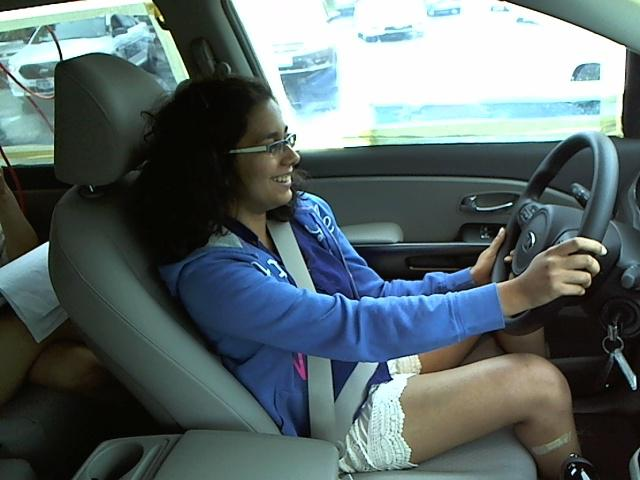

[0.9982, 0.0, 0.0, 0.001, 0.0002, 0.0, 0.0, 0.0, 0.0, 0.0005]
Predicted class: safe driving
Confidence: 0.9982
2nd answer: texting - left
Confidence: 0.001


In [ ]:
file = random.choice(list_img_test)
im_path = os.path.join(path_test,file)
display(Image(filename=im_path))
with PIL.Image.open(im_path) as im:
    im = transform(im)
    im = im.unsqueeze(0)
    output = model(im.cuda())
    proba = nn.Softmax(dim=1)(output)
    proba = [round(float(elem),4) for elem in proba[0]]
    print(proba)
    print("Predicted class:",class_dict[proba.index(max(proba))])
    print("Confidence:",max(proba))
    proba2 = proba.copy()
    proba2[proba2.index(max(proba2))] = 0.
    print("2nd answer:",class_dict[proba2.index(max(proba2))])
    print("Confidence:",max(proba2))

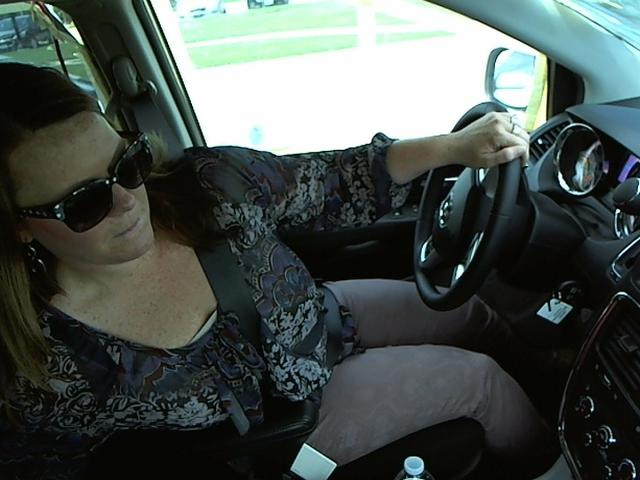

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9998, 0.0002, 0.0]
Predicted class: reaching behind
Confidence: 0.9998
2nd answer: hair and makeup
Confidence: 0.0002


In [ ]:
file = random.choice(list_img_test)
im_path = os.path.join(path_test,file)
display(Image(filename=im_path))
with PIL.Image.open(im_path) as im:
    im = transform(im)
    im = im.unsqueeze(0)
    output = model(im.cuda())
    proba = nn.Softmax(dim=1)(output)
    proba = [round(float(elem),4) for elem in proba[0]]
    print(proba)
    print("Predicted class:",class_dict[proba.index(max(proba))])
    print("Confidence:",max(proba))
    proba2 = proba.copy()
    proba2[proba2.index(max(proba2))] = 0.
    print("2nd answer:",class_dict[proba2.index(max(proba2))])
    print("Confidence:",max(proba2))

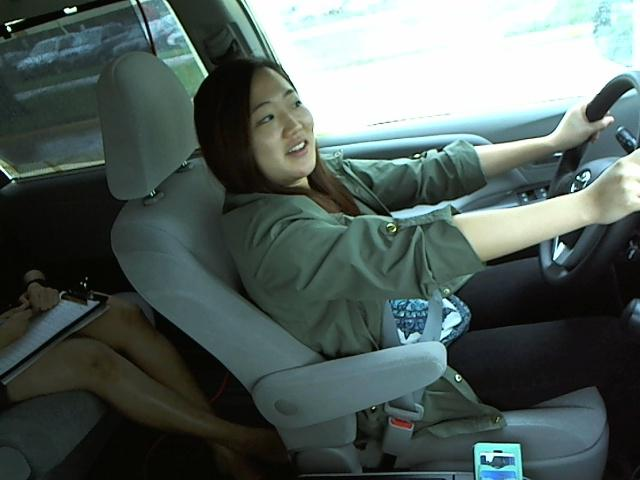

[0.9416, 0.0001, 0.0002, 0.0013, 0.0018, 0.0008, 0.0, 0.0001, 0.0011, 0.0531]
Predicted class: safe driving
Confidence: 0.9416
2nd answer: talking to passenger
Confidence: 0.0531


In [ ]:
file = random.choice(list_img_test)
im_path = os.path.join(path_test,file)
display(Image(filename=im_path))
with PIL.Image.open(im_path) as im:
    im = transform(im)
    im = im.unsqueeze(0)
    output = model(im.cuda())
    proba = nn.Softmax(dim=1)(output)
    proba = [round(float(elem),4) for elem in proba[0]]
    print(proba)
    print("Predicted class:",class_dict[proba.index(max(proba))])
    print("Confidence:",max(proba))
    proba2 = proba.copy()
    proba2[proba2.index(max(proba2))] = 0.
    print("2nd answer:",class_dict[proba2.index(max(proba2))])
    print("Confidence:",max(proba2))

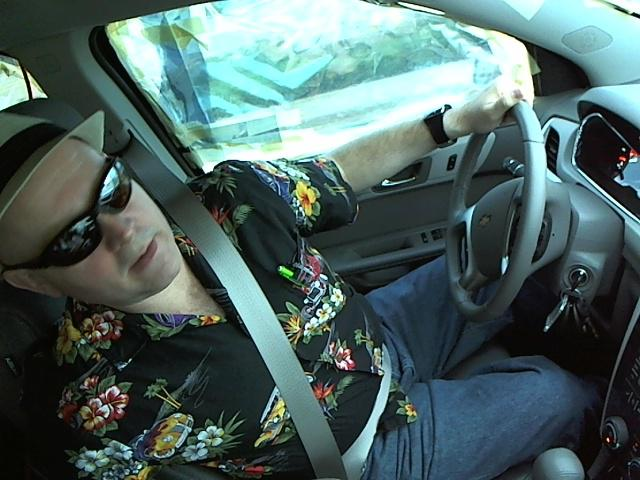

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9998, 0.0, 0.0001]
Predicted class: reaching behind
Confidence: 0.9998
2nd answer: talking to passenger
Confidence: 0.0001


In [ ]:
file = random.choice(list_img_test)
im_path = os.path.join(path_test,file)
display(Image(filename=im_path))
with PIL.Image.open(im_path) as im:
    im = transform(im)
    im = im.unsqueeze(0)
    output = model(im.cuda())
    proba = nn.Softmax(dim=1)(output)
    proba = [round(float(elem),4) for elem in proba[0]]
    print(proba)
    print("Predicted class:",class_dict[proba.index(max(proba))])
    print("Confidence:",max(proba))
    proba2 = proba.copy()
    proba2[proba2.index(max(proba2))] = 0.
    print("2nd answer:",class_dict[proba2.index(max(proba2))])
    print("Confidence:",max(proba2))

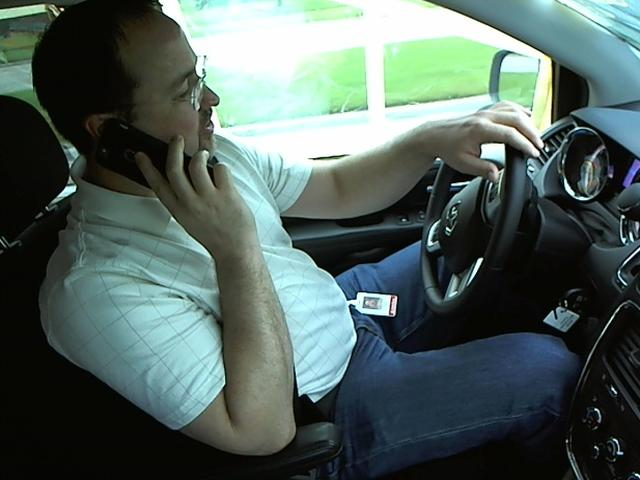

[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Predicted class: talking on the phone - right
Confidence: 1.0
2nd answer: safe driving
Confidence: 0.0


In [ ]:
file = random.choice(list_img_test)
im_path = os.path.join(path_test,file)
display(Image(filename=im_path))
with PIL.Image.open(im_path) as im:
    im = transform(im)
    im = im.unsqueeze(0)
    output = model(im.cuda())
    proba = nn.Softmax(dim=1)(output)
    proba = [round(float(elem),4) for elem in proba[0]]
    print(proba)
    print("Predicted class:",class_dict[proba.index(max(proba))])
    print("Confidence:",max(proba))
    proba2 = proba.copy()
    proba2[proba2.index(max(proba2))] = 0.
    print("2nd answer:",class_dict[proba2.index(max(proba2))])
    print("Confidence:",max(proba2))

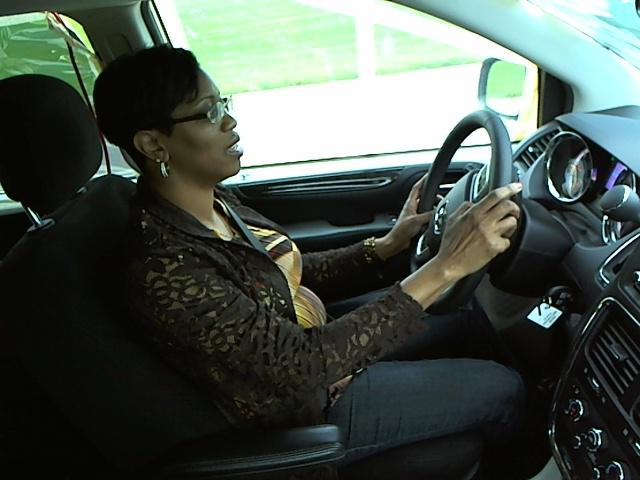

[0.987, 0.0005, 0.0001, 0.0108, 0.0012, 0.0003, 0.0002, 0.0, 0.0, 0.0]
Predicted class: safe driving
Confidence: 0.987
2nd answer: texting - left
Confidence: 0.0108


In [ ]:
file = random.choice(list_img_test)
im_path = os.path.join(path_test,file)
display(Image(filename=im_path))
with PIL.Image.open(im_path) as im:
    im = transform(im)
    im = im.unsqueeze(0)
    output = model(im.cuda())
    proba = nn.Softmax(dim=1)(output)
    proba = [round(float(elem),4) for elem in proba[0]]
    print(proba)
    print("Predicted class:",class_dict[proba.index(max(proba))])
    print("Confidence:",max(proba))
    proba2 = proba.copy()
    proba2[proba2.index(max(proba2))] = 0.
    print("2nd answer:",class_dict[proba2.index(max(proba2))])
    print("Confidence:",max(proba2))

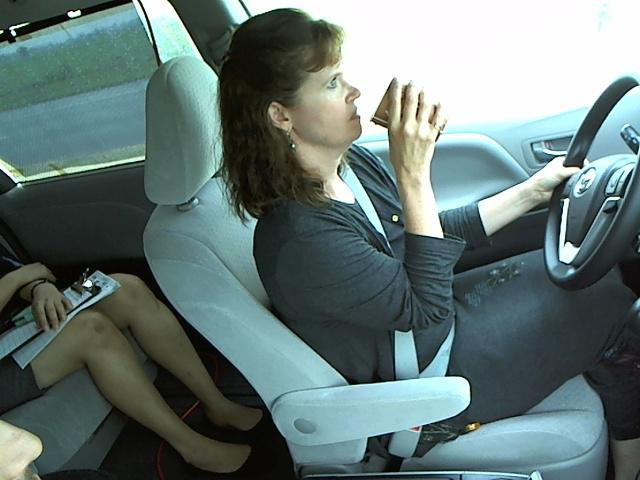

[0.0, 0.0, 0.0, 0.0, 0.0001, 0.0, 0.9998, 0.0, 0.0001, 0.0]
Predicted class: drinking
Confidence: 0.9998
2nd answer: talking on the phone - left
Confidence: 0.0001


In [ ]:
file = random.choice(list_img_test)
im_path = os.path.join(path_test,file)
display(Image(filename=im_path))
with PIL.Image.open(im_path) as im:
    im = transform(im)
    im = im.unsqueeze(0)
    output = model(im.cuda())
    proba = nn.Softmax(dim=1)(output)
    proba = [round(float(elem),4) for elem in proba[0]]
    print(proba)
    print("Predicted class:",class_dict[proba.index(max(proba))])
    print("Confidence:",max(proba))
    proba2 = proba.copy()
    proba2[proba2.index(max(proba2))] = 0.
    print("2nd answer:",class_dict[proba2.index(max(proba2))])
    print("Confidence:",max(proba2))

In [ ]:
def true_pred(test_data,model):
    y_true = []
    y_pred = []
    n = len(test_data)
    sum = 0
    with torch.no_grad():
        for x,y in tqdm(test_data):
            x = x.to(device)
            pred = torch.argmax(model(x),dim=1)
            y_true.extend(list(np.array(y)))
            y_pred.extend(list(np.array(pred.cpu())))
    return y_true,y_pred

In [ ]:
y_true,y_pred = true_pred(test_loader,model)

100%|██████████| 141/141 [00:57<00:00,  2.45it/s]


In [ ]:
m = confusion_matrix(y_true, y_pred)
m  = m.astype('float') / m.sum(axis=1)[:, np.newaxis]

<AxesSubplot:>

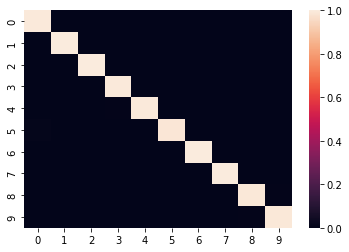

In [ ]:
sns.heatmap(m)

We need to create a '/test/test' so that we can use `datasets.ImageFolder` and use a loader which is faster than iterating one by one (40 minutes) through all imgs/test files.

In [ ]:
os.mkdir("test")

In [ ]:
for img in tqdm(list_img_test):
    os.mkdir("test/"+img[:-4])
    source = path_test+"/"+img
    destination = "test/"+img[:-4]+"/"+img
    shutil.copy(source, destination)

In [ ]:
transform_test = transforms.Compose([transforms.Resize((400, 400)),
                                     #transforms.RandomRotation(10),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ])

In [ ]:
datatest = datasets.ImageFolder(root = "/test",
                                transform = transform_test)

In [ ]:
loader = torch.utils.data.DataLoader(dataset=datatest,
                                     batch_size=16,
                                     shuffle=False,
                                     drop_last=False,
                                     num_workers=2)

In [ ]:
x,y = next(iter(loader))

In [ ]:
print(x.shape)
print(y)
plt.figure(figsize=(16,16))
plt.imshow(torchvision.utils.make_grid(x,nrow=8).permute((1,2,0)))
plt.axis('off')
plt.show()